In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import neattext.functions as nfx
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

2025-03-09 20:04:40.424096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 20:04:40.581727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741530880.680034   24234 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741530880.705037   24234 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 20:04:40.847299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
df = pd.read_excel("/home/fariz/Works/Malayalam-Emotion-Detector/github_test/Emotions data.xlsx")

In [3]:
df.head()

,Text,Emotion
0,ബാക്കി പരലോകത്ത് വെച്ച് ചർച്ചചെയ്യാം,Excitement
1,കഴിഞ്ഞില്ല സൈമ ഇത് കഴിഞ്ഞ് ഒരു സുനാമി വരവ് ഇണ്ട്,Excitement
2,തേച്ചത് അവനല്ലേ. പിന്നെ എന്തുവാ ഈ കാണിക്കുന്നേ,Humour
3,ഒരാളെ ജീവിതത്തിലേക്ക് ഒളിഞ്ഞു നോക്കാനുള്ള മലയാ...,Humour
4,പെണ്ണിന് പകരം പബ്ജിയെ സ്നേഹിക്കു മോനെ,Humour


In [4]:
df.head()


,Text,Emotion
0,ബാക്കി പരലോകത്ത് വെച്ച് ചർച്ചചെയ്യാം,Excitement
1,കഴിഞ്ഞില്ല സൈമ ഇത് കഴിഞ്ഞ് ഒരു സുനാമി വരവ് ഇണ്ട്,Excitement
2,തേച്ചത് അവനല്ലേ. പിന്നെ എന്തുവാ ഈ കാണിക്കുന്നേ,Humour
3,ഒരാളെ ജീവിതത്തിലേക്ക് ഒളിഞ്ഞു നോക്കാനുള്ള മലയാ...,Humour
4,പെണ്ണിന് പകരം പബ്ജിയെ സ്നേഹിക്കു മോനെ,Humour


In [5]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [6]:
df['Emotion'].value_counts()


Emotion
Excitement    1000
Humour        1000
Anger         1000
Sad           1000
Abusive       1000
Love          1000
Fear          1000
Happy         1000
Surprise      1000
Sarcasm       1000
Name: count, dtype: int64

In [7]:
df['Text'] = df['Text'].apply(nfx.remove_punctuations)


In [8]:
# Convert emotions to numerical labels
emotion_labels = df['Emotion'].astype('category').cat.codes
label_mapping = dict(enumerate(df['Emotion'].astype('category').cat.categories))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Abusive', 1: 'Anger', 2: 'Excitement', 3: 'Fear', 4: 'Happy', 5: 'Humour', 6: 'Love', 7: 'Sad', 8: 'Sarcasm', 9: 'Surprise'}


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], emotion_labels, test_size=0.3, random_state=42)

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [11]:
# Tokenize training data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Tokenize test data
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

In [12]:
# Convert to PyTorch datasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.tolist()))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.tolist()))

In [13]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
optimizer = AdamW(model.parameters(), lr=2e-5)


/home/fariz/Works/Malayalam-Emotion-Detector/env/lib64/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 2.296342912874265
Epoch 2, Loss: 2.2830165504864905
Epoch 3, Loss: 2.2725748229244527


In [18]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(true_labels, predictions, target_names=list(label_mapping.values())))

              precision    recall  f1-score   support

     Abusive       0.09      0.55      0.15       278
       Anger       0.16      0.15      0.15       294
  Excitement       0.14      0.15      0.14       313
        Fear       0.00      0.00      0.00       316
       Happy       0.00      0.00      0.00       295
      Humour       0.00      0.00      0.00       316
        Love       0.19      0.34      0.24       277
         Sad       0.32      0.03      0.06       286
     Sarcasm       0.10      0.03      0.05       306
    Surprise       0.00      0.00      0.00       319

    accuracy                           0.12      3000
   macro avg       0.10      0.12      0.08      3000
weighted avg       0.10      0.12      0.08      3000



/home/fariz/Works/Malayalam-Emotion-Detector/env/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fariz/Works/Malayalam-Emotion-Detector/env/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fariz/Works/Malayalam-Emotion-Detector/env/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Text(0.5, 1.0, 'Confusion Matrix')

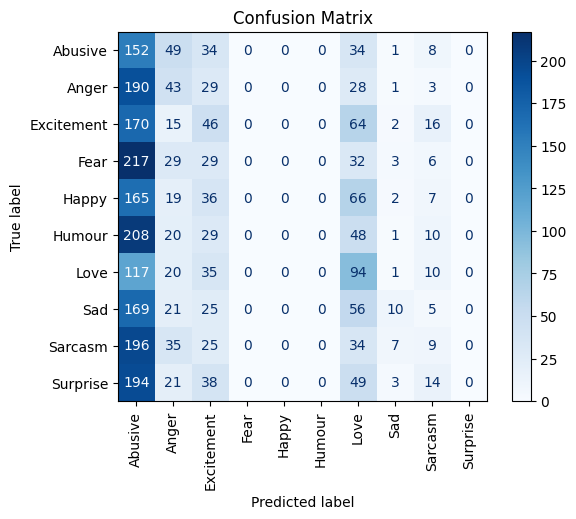

In [19]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
disp.plot(cmap='Blues', xticks_rotation='vertical')
sns.set(rc={'figure.figsize':(8,6)})
disp.ax_.set_title("Confusion Matrix")

In [20]:
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).cpu().numpy()
    return label_mapping[pred[0]]

# Example
review = ["സ്നേഹം ഒരുപാട് മാറ്റങ്ങൾ കൊണ്ടു വരും"]
print(f"Predicted Emotion: {predict_emotion(review)}")

Predicted Emotion: Humour


In [2]:
import os

# Create a directory to save the model and tokenizer
output_dir = "./bert_emotion_model"
os.makedirs(output_dir, exist_ok=True)

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

# Save the label mapping
import json
with open(os.path.join(output_dir, "label_mapping.json"), "w") as f:
    json.dump(label_mapping, f)

print(f"Model, tokenizer, and label mapping saved to {output_dir}")

NameError: name 'model' is not defined